# **PART 1**:

## Face detection model

### Importing all the libraries for the entire project here

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from skimage import io
from PIL import Image
from google.colab import drive
from skimage.transform import rescale, resize, downscale_local_mean
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Concatenate, UpSampling2D, Convolution2D, Reshape,ZeroPadding2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.utils import to_categorical

In [ ]:
drive.mount('/content/drive/')
project_path = '/content/drive/My Drive/Data Science/Project 9/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 1. **Import the dataset**

In [ ]:
os.chdir(project_path)
!ls

#viewing all the files in the directory

'CV - Project.pdf'		   'Project 9.ipynb'	    resized_arrays.npy
'Part 1- Train data - images.npy'   resized_arrays.np.npy


In [ ]:
data = np.load('/content/drive/My Drive/Data Science/Project 9/Part 1- Train data - images.npy',allow_pickle=True)
#Loading the file from drive

In [ ]:
image_height = set()
image_width = set()
gray_scale = []
for i,j in data:  
    image_height.add(i.shape[0])
    image_width.add(i.shape[1])

# #Identifying all the shapes of images, their height, width and number of channels to resize it to the right shape

In [ ]:
print(f"We have the minimum image height {min(image_height)} and maximum image height as {max(image_height)}, there is a varying size of image height.")

We have the minimum image height 180 and maximum image height as 4016, there is a varying size of image height.


In [ ]:
print(f"We have the minimum image width {min(image_width)} and maximum image width as {max(image_width)}, there is a varying size of image width.")

We have the minimum image width 182 and maximum image width as 6016, there is a varying size of image width.


In [ ]:
#To collect all images as numpy arrays with shape of 224x224
data1 = np.zeros((len(data), 224, 224,3))

#To collect the labels
Label = []

#To collect bounding boxes coordinates
bounding_boxes = np.zeros((sum(1 for line in data), 224,224))

#Capture image dimensions just in case it is needed
image_dimension = np.zeros((sum(1 for line in data), 2))

#To capture masks
masks = np.zeros((int(data.shape[0]), 224, 224))

In [ ]:
data1.shape

#To collect images

(409, 224, 224, 3)

In [ ]:
X_train.shape

(409, 224, 224, 3)

## **2. Create features (images) and labels (mask) using that data.**

In [ ]:
for i in range(data.shape[0]):
    data1[i,:,:,:] = resize(data[i][0],(224,224,3))
    for j in data[i][1]:
        masks[i][int(j["points"][0]['y'] * 224):int(j["points"][1]['y'] * 224), int(j["points"][0]['x'] * 224):int(j["points"][1]['x'] * 224)] = 1

#Prepared the image array in the shape 224 x 224 x 3 and its masks

In [ ]:
#Saving the numpy arrays
# np.save('/content/drive/My Drive/Data Science/Project 9/resized_arrays.npy',data1)
# np.save('/content/drive/My Drive/Data Science/Project 9/masks.npy',masks)

#Loading the numpy arrays
data1 = np.load('/content/drive/My Drive/Data Science/Project 9/resized_arrays.npy')
masks = np.load('/content/drive/My Drive/Data Science/Project 9/masks.npy')

#Saving the array just incase we wish to reload the notebook, We can load the saved numpyarrays without the need to recreate the arrays from input 
#image

In [ ]:
data1.shape

#Image arrays shape

(409, 224, 224, 3)

In [ ]:
masks.shape

#Masks shape

(409, 224, 224)

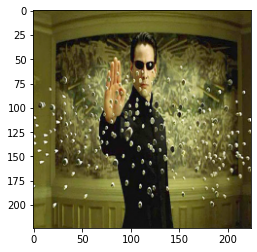

In [ ]:
plt.imshow(data1[66])

#Viewing an image and its mask

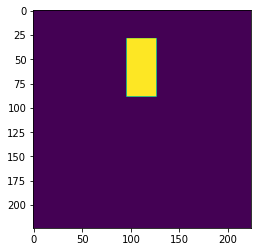

In [ ]:
plt.imshow(masks[66])

#Mask of the above image

# **3. Mask detection model:**
 * Design a face mask detection model.
    * Hint: Use U-net along with pre-trained transfer learning models

# **Model: MobileNet**

In [ ]:
model = MobileNet(input_shape=(224,224,3),alpha=1,include_top=False)

# We will try Mobilenet as it is the best and fastest

In [ ]:
for layer in model.layers:
    layer.trainable = False

In [ ]:
block1 = model.get_layer('conv_pw_1_relu').output
block5 = model.get_layer('conv_pw_3_relu').output
block9 = model.get_layer('conv_pw_5_relu').output
block21 = model.get_layer('conv_pw_11_relu').output
block25 = model.get_layer('conv_pw_13_relu').output

op = Concatenate()([UpSampling2D()(block25), block21])
op = Concatenate()([UpSampling2D()(op), block9])
op = Concatenate()([UpSampling2D()(op), block5])
op = Concatenate()([UpSampling2D()(op), block1])

op = UpSampling2D()(op)
op = Convolution2D(1, kernel_size = 1, activation = "sigmoid")(op)
op = Reshape((224, 224))(op)

model_Mobile_net = Model(inputs = model.input, outputs = op)

In [ ]:
model_Mobile_net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
____________________________________________________________________________________________

 * Design your own Dice Coefficient and Loss function.

In [ ]:
def dice_coeff(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

In [ ]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coeff(y_true, y_pred) + tf.keras.backend.epsilon())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data1, masks, test_size=0.33, random_state=42)

*   Train, tune and test the model.



## Using Adam optimizer with default values - 10 epochs

In [ ]:
model_Mobile_net.compile(loss=loss, optimizer='adam', metrics=[dice_coeff])
ES = EarlyStopping(monitor='loss', min_delta=0.1, patience=10)
RLP = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [ ]:
model_Mobile_net.fit(X_train,y_train,batch_size=5, epochs=10,validation_data=(X_test,y_test),callbacks=[ES,RLP])
# Trying with Adam optimizer with default hyperparameters

Epoch 1/10
55/55 [==============================] - 13s 208ms/step - loss: 1.3482 - dice_coeff: 0.4084 - val_loss: 0.9064 - val_dice_coeff: 0.5306
Epoch 2/10
55/55 [==============================] - 10s 179ms/step - loss: 0.8556 - dice_coeff: 0.5610 - val_loss: 0.8358 - val_dice_coeff: 0.5604
Epoch 3/10
55/55 [==============================] - 10s 187ms/step - loss: 0.8066 - dice_coeff: 0.5823 - val_loss: 0.7796 - val_dice_coeff: 0.5876
Epoch 4/10
55/55 [==============================] - 10s 188ms/step - loss: 0.7360 - dice_coeff: 0.6121 - val_loss: 0.7551 - val_dice_coeff: 0.6079
Epoch 5/10
55/55 [==============================] - 10s 189ms/step - loss: 0.7105 - dice_coeff: 0.6241 - val_loss: 0.7361 - val_dice_coeff: 0.6107
Epoch 6/10
55/55 [==============================] - 10s 191ms/step - loss: 0.6955 - dice_coeff: 0.6301 - val_loss: 0.7461 - val_dice_coeff: 0.6147
Epoch 7/10
55/55 [==============================] - 10s 192ms/step - loss: 0.6795 - dice_coeff: 0.6347 - val_loss: 0.7

# Using SGD optimizer with default values - 10 epochs

In [ ]:
model_Mobile_net.compile(loss=loss, optimizer='sgd', metrics=[dice_coeff])
ES = EarlyStopping(monitor='loss', min_delta=0.1, patience=10)
RLP = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [ ]:
model_Mobile_net.fit(X_train,y_train,batch_size=5, epochs=10,validation_data=(X_test,y_test),callbacks=[ES,RLP])
# Trying with SGD  optimizer with default hyperparameters

Epoch 1/10
55/55 [==============================] - 12s 198ms/step - loss: 1.5961 - dice_coeff: 0.4494 - val_loss: 0.8510 - val_dice_coeff: 0.5782
Epoch 2/10
55/55 [==============================] - 10s 191ms/step - loss: 0.9219 - dice_coeff: 0.5658 - val_loss: 0.8010 - val_dice_coeff: 0.6043
Epoch 3/10
55/55 [==============================] - 11s 192ms/step - loss: 0.7970 - dice_coeff: 0.6053 - val_loss: 0.7711 - val_dice_coeff: 0.5987
Epoch 4/10
55/55 [==============================] - 11s 192ms/step - loss: 0.7817 - dice_coeff: 0.6107 - val_loss: 0.7624 - val_dice_coeff: 0.6177
Epoch 5/10
55/55 [==============================] - 10s 190ms/step - loss: 0.7675 - dice_coeff: 0.6153 - val_loss: 0.7444 - val_dice_coeff: 0.6253
Epoch 6/10
55/55 [==============================] - 10s 183ms/step - loss: 0.7311 - dice_coeff: 0.6273 - val_loss: 0.7621 - val_dice_coeff: 0.6214
Epoch 7/10
55/55 [==============================] - 10s 189ms/step - loss: 0.7002 - dice_coeff: 0.6358 - val_loss: 0.7

# Using RMSprop optimizer with default values - 10 epochs

In [ ]:
model_Mobile_net.compile(loss=loss, optimizer='rmsprop', metrics=[dice_coeff])
ES = EarlyStopping(monitor='loss', min_delta=0.1, patience=10)
RLP = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [ ]:
model_Mobile_net.fit(X_train,y_train,batch_size=5, epochs=10,validation_data=(X_test,y_test),callbacks=[ES,RLP])
# Trying with RMSprop optimizer with default hyperparameters

Epoch 1/10
55/55 [==============================] - 12s 191ms/step - loss: 1.4771 - dice_coeff: 0.3726 - val_loss: 0.9335 - val_dice_coeff: 0.5251
Epoch 2/10
55/55 [==============================] - 10s 184ms/step - loss: 0.8832 - dice_coeff: 0.5482 - val_loss: 0.8112 - val_dice_coeff: 0.5709
Epoch 3/10
55/55 [==============================] - 10s 186ms/step - loss: 0.7883 - dice_coeff: 0.5918 - val_loss: 0.7512 - val_dice_coeff: 0.6050
Epoch 4/10
55/55 [==============================] - 11s 193ms/step - loss: 0.7312 - dice_coeff: 0.6172 - val_loss: 0.7801 - val_dice_coeff: 0.5921
Epoch 5/10
55/55 [==============================] - 10s 184ms/step - loss: 0.7255 - dice_coeff: 0.6216 - val_loss: 0.7291 - val_dice_coeff: 0.6170
Epoch 6/10
55/55 [==============================] - 10s 189ms/step - loss: 0.6853 - dice_coeff: 0.6391 - val_loss: 0.7410 - val_dice_coeff: 0.6097
Epoch 7/10
55/55 [==============================] - 10s 189ms/step - loss: 0.6721 - dice_coeff: 0.6434 - val_loss: 0.7

1.   Adam Optimizer:
 -  loss: 0.6444 - val_loss: 0.7197 
 - dice_coeff: 0.6516 - val_dice_coeff: 0.6226

2.   SGD Optmizer:
 - loss: 0.6813 - val_loss: 0.7198 
 - dice_coeff: 0.6427 - val_dice_coeff: 0.6270

3.  RMS prop optimizer:
  - loss: 0.6330, val_loss: 0.7224 
  - dice_coeff: 0.6596 - val_dice_coeff: 0.6261


## **The Validation loss is the least for Adam Optmizer but Dicecoefficient looks the best for both training and validation in SGD optimizer. We try to take Adam optimizer and edit hyperparameters and retrain the model**

In [ ]:
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-05)
model_Mobile_net.compile(loss=loss, optimizer=adam, metrics=[dice_coeff])
ES = EarlyStopping(monitor='loss', min_delta=0.1, patience=10)
RLP = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [ ]:
model_Mobile_net.fit(X_train,y_train,batch_size=10, epochs=100,validation_data=(X_test,y_test),callbacks=[ES,RLP])

Epoch 1/100
28/28 [==============================] - 12s 376ms/step - loss: 1.4270 - dice_coeff: 0.3760 - val_loss: 0.9562 - val_dice_coeff: 0.5180
Epoch 2/100
28/28 [==============================] - 10s 364ms/step - loss: 0.9249 - dice_coeff: 0.5281 - val_loss: 0.8252 - val_dice_coeff: 0.5633
Epoch 3/100
28/28 [==============================] - 10s 364ms/step - loss: 0.8082 - dice_coeff: 0.5730 - val_loss: 0.7836 - val_dice_coeff: 0.5944
Epoch 4/100
28/28 [==============================] - 10s 360ms/step - loss: 0.7662 - dice_coeff: 0.5953 - val_loss: 0.7454 - val_dice_coeff: 0.6013
Epoch 5/100
28/28 [==============================] - 10s 357ms/step - loss: 0.7343 - dice_coeff: 0.6112 - val_loss: 0.7196 - val_dice_coeff: 0.6177
Epoch 6/100
28/28 [==============================] - 10s 355ms/step - loss: 0.6951 - dice_coeff: 0.6240 - val_loss: 0.7124 - val_dice_coeff: 0.6228
Epoch 7/100
28/28 [==============================] - 10s 354ms/step - loss: 0.6854 - dice_coeff: 0.6298 - val_lo

In [ ]:
model_Mobile_net.save('/content/drive/My Drive/Data Science/Project 9/model_Mobile_net_Adam.h5',)
#Saving this model

## ● Evaluate the model using testing data.

In [ ]:
Newmodel = load_model('/content/drive/My Drive/Data Science/Project 9/model_Mobile_net_Adam.h5',custom_objects={'loss':loss,'dice_coeff':dice_coeff})

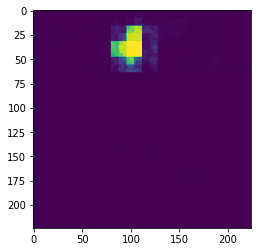

In [ ]:
plt.imshow(Newmodel.predict(X_test[100].reshape(1,224,224,3)).reshape(224,224))
#Prediction

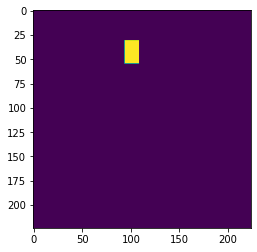

In [ ]:
plt.imshow(y_test[100])
#Actual

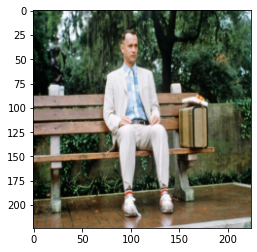

In [ ]:
plt.imshow(X_test[100])

## **4. Use the “Prediction image” as an input to your designed model and display the output of the image.**

In [ ]:
prediction_image = np.array(Image.open('/content/drive/My Drive/Data Science/Project 9/Part 1Test Data - Prediction Image.jpeg'))

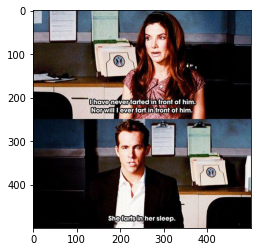

In [ ]:
plt.imshow(prediction_image)

In [ ]:
pre = Newmodel.predict(resize(prediction_image,(224,224,3)).reshape(1,224,224,3))

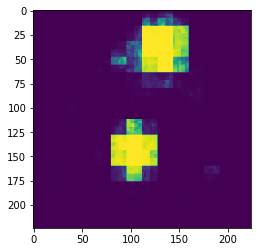

In [ ]:
plt.imshow(pre.reshape(224,224))

#Not bad for the metrics we saw during training, it is able to predict 2 faces in different location

# **Part 3** : Face recognition

In [ ]:
import zipfile
!unzip '/content/drive/My Drive/Data Science/Project 9/Part3/Part 3 - Aligned Face Dataset from Pinterest.zip' -d '/content/drive/My Drive/Data Science/Project 9/Part3/Input/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/My Drive/Data Science/Project 9/Part3/Input/pins/PINS/pins_Sophie Turner/Sophie Turner57_1691.jpg  
  inflating: /content/drive/My Drive/Data Science/Project 9/Part3/Input/pins/PINS/pins_Sophie Turner/Sophie Turner58_1668.jpg  
  inflating: /content/drive/My Drive/Data Science/Project 9/Part3/Input/pins/PINS/pins_Sophie Turner/Sophie Turner59_1653.jpg  
  inflating: /content/drive/My Drive/Data Science/Project 9/Part3/Input/pins/PINS/pins_Sophie Turner/Sophie Turner5_1638.jpg  
  inflating: /content/drive/My Drive/Data Science/Project 9/Part3/Input/pins/PINS/pins_Sophie Turner/Sophie Turner60_1650.jpg  
  inflating: /content/drive/My Drive/Data Science/Project 9/Part3/Input/pins/PINS/pins_Sophie Turner/Sophie Turner61_1725.jpg  
  inflating: /content/drive/My Drive/Data Science/Project 9/Part3/Input/pins/PINS/pins_Sophie Turner/Sophie Turner62_1698.jpg  
  inflating: /content/drive/My Drive/Data Science/Proj

## **• Load the dataset and create the metadata.**

### **In this case i am not sure what you mean by Metadata, in general its like an information about the data. Below are few of the combinations that i tried to display as metadata**

In [ ]:
# Data = pd.read_csv('/content/drive/My Drive/Data Science/Project 9/Part3/Data.csv',index_col=False)
#In case of rerunning the code, use the above to load the data

In [ ]:
#MetaData type 1

project_path = '/content/drive/My Drive/Data Science/Project 9/Part3/Input/PINS/'
Data = pd.DataFrame(columns=['filename','class','Extension'])
for dirname,j,filenames in os.walk(project_path):
    for filename in filenames:
        Data = Data.append({'filename':os.path.join(dirname, filename) , 'class':dirname.split('/')[-1], 'Extension':filename.split('/')[-1].split('.')[-1]}, ignore_index = True)

#Data.to_csv('/content/drive/My Drive/Data Science/Project 9/Part3/Data.csv',index=False)
#Saving for future use

In [ ]:
Data.head()

,filename,class,Extension
0,/content/drive/My Drive/Data Science/Project 9...,pins_Aaron Paul,jpg
1,/content/drive/My Drive/Data Science/Project 9...,pins_Aaron Paul,jpg
2,/content/drive/My Drive/Data Science/Project 9...,pins_Aaron Paul,jpg
3,/content/drive/My Drive/Data Science/Project 9...,pins_Aaron Paul,jpg
4,/content/drive/My Drive/Data Science/Project 9...,pins_Aaron Paul,jpg


In [ ]:
#Metadata type 2

def get_metadata(x):
    Unique_Classes = list((x['class'].unique()))
    File_extension_type = set([x['filename'].iloc[i].split('/')[-1].split('.')[-1] for i in range(len(x))])
    print(f"The number of Unique Classes is {len(Unique_Classes)}")
    print(f"The Unique image extension types are {[i for i in File_extension_type]}")
    return Unique_Classes,File_extension_type

In [ ]:
Unique_Classes,File_extension_type = get_metadata(Data)

The number of Unique Classes is 100
The Unique image extension types are ['jpg']


In [ ]:
File_extension_type

{'jpg'}

In [ ]:
Unique_Classes

['pins_Aaron Paul',
 'pins_Alvaro Morte',
 'pins_Amanda Crew',
 'pins_Amaury Nolasco',
 'pins_Anna Gunn',
 'pins_Benedict Cumberbatch',
 'pins_Betsy Brandt',
 'pins_Brenton Thwaites',
 'pins_Brit Marling',
 'pins_Bryan Cranston',
 'pins_Caity Lotz',
 'pins_Cameron Monaghan',
 'pins_Chance Perdomo',
 'pins_Chris Evans',
 'pins_Chris Pratt',
 'pins_Cobie Smulders',
 'pins_Danielle Panabaker',
 'pins_Dave Franco',
 'pins_Dominic Purcell',
 'pins_Dwayne Johnson',
 'pins_Emilia Clarke',
 'pins_Emily Bett Rickards',
 'pins_Emma Stone',
 'pins_Gwyneth Paltrow',
 'pins_Henry Cavil',
 'pins_Jason Momoa',
 'pins_Jeremy Renner',
 'pins_Jesse Eisenberg',
 'pins_Jim Parsons',
 'pins_Jon Bernthal',
 'pins_Josh Radnor',
 'pins_Kit Harington',
 'pins_Krysten Ritter',
 'pins_Kumail Nanjiani',
 'pins_Maisie Williams',
 'pins_Mark Ruffalo',
 'pins_Martin Starr',
 'pins_Melissa benoit',
 'pins_Mike Colter',
 'pins_Morena Baccarin',
 'pins_Morgan Freeman',
 'pins_Natalie Portman ',
 'pins_Neil Patrick Harr

## **• Check some samples of metadata.**

The image class ispins_Aaron Paul

The image extension is .jpg



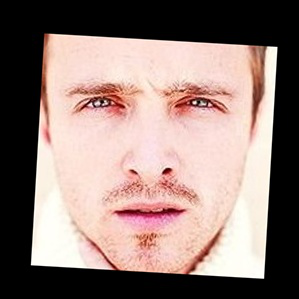

In [ ]:
print(f"The image class is{Data['class'].iloc[0]}" + '\n')
print(f"The image extension is .{Data['Extension'].iloc[0]}" + '\n')
Image.open(Data['filename'].iloc[0])

The image class ispins_Alvaro Morte

The image extension is .jpg



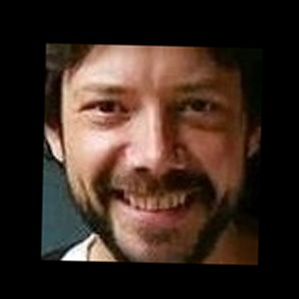

In [ ]:
print(f"The image class is{Data['class'].iloc[107]}" + '\n')
print(f"The image extension is .{Data['Extension'].iloc[107]}" + '\n')
Image.open(Data['filename'].iloc[107])

## **• Load the pre-trained model and weights.**

In [ ]:
def VGG_model():	
    model = Sequential()
    model.add(ZeroPadding2D((1, 1),  input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [ ]:
model = VGG_model()
model.load_weights('/content/drive/My Drive/Data Science/Project 9/Part3/Part 3 - vgg_face_weights.h5')
VGG_Model = Model(inputs=model.layers[0].input, outputs = model.layers[-2].output)

In [ ]:
#Function to resize the image and give it ready for submitting to model

def Image_resize(x):
    img = io.imread(x)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224, 224))
    return img  

In [ ]:
#Function to pull Embedding vector

def embeddings(x):
    img = Image_resize(x)
    embedding_vector1 = VGG_Model.predict(np.expand_dims(img, axis = 0))[0]
    return embedding_vector1

In [ ]:
embedding_vector = embeddings(Data['filename'].iloc[0])

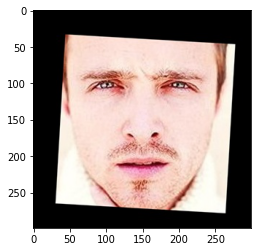

In [ ]:
plt.imshow(io.imread(Data['filename'].iloc[0]))

In [ ]:
embedding_vector1 = embeddings(Data['filename'].iloc[85])

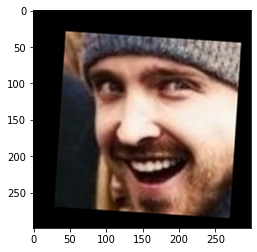

In [ ]:
plt.imshow(io.imread(Data['filename'].iloc[85]))

In [ ]:
def L2_distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [ ]:
L2_distance(embedding_vector,embedding_vector1)

0.30172002

### **Generate Embedding vectors for each face in the dataset.**

In [ ]:
embedding_pred_all = np.zeros((Data.shape[0], 2622))

for i in range(len(Data)):
    print(i)
    embedding_pred_all[i] = VGG_Model.predict(np.expand_dims(Image_resize(Data['filename'].iloc[i]), axis = 0))[0]
    # embedding_pred_all[i] = VGG_Model.predict(np.expand_dims(io.imread(Data['filename'].iloc[i]), axis = 0))[0]

    #Generating Embeddings for all the images in the dataset and saving it as an Numpy Array

## Build distance metrics for identifying the distance between two given images.

In [ ]:
# np.save('/content/drive/My Drive/Data Science/Project 9/embedding_pred_all.npy',embedding_pred_all)
# Saving so that in case of rerunning we can load it back

# embedding_pred_all =  np.load('/content/drive/My Drive/Data Science/Project 9/embedding_pred_all.npy')
# Reload the embedding later

# Calculate L2  Distance - Method 1
# from tensorflow.keras import backend as K
# def L2_distance(emb1, emb2):
#   return K.sqrt(K.sum(K.square(emb1- emb2), axis=-1, keepdims=True))

# Calculate L2  Distance - Method 2
# def L2_distance(emb1, emb2):
#   return np.sum(np.square(emb1 - emb2))

In [ ]:
def Solution(x, y):
    embedding_pred1 = embeddings(Data['filename'].iloc[x])
    embedding_pred = embeddings(Data['filename'].iloc[y])
    plt.suptitle(f'Distance = {L2_distance(embedding_pred, embedding_pred1)}')
    # plt.suptitle(f'Distance = {L2_distance(embedding_pred[x], embedding_pred1[y]):.2f}')
    plt.subplot(121)
    plt.imshow(io.imread(Data['filename'].iloc[x]))
    plt.subplot(122)
    plt.imshow(io.imread(Data['filename'].iloc[y]));  

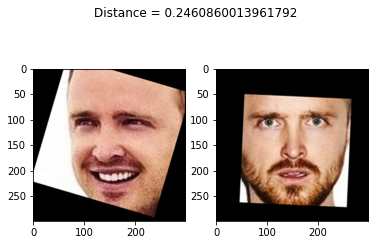

In [ ]:
Solution(1,32)
#Example1 of Same images

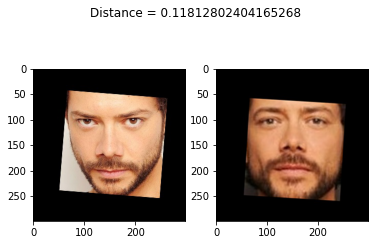

In [ ]:
Solution(96,102)
#Example2 of Same images

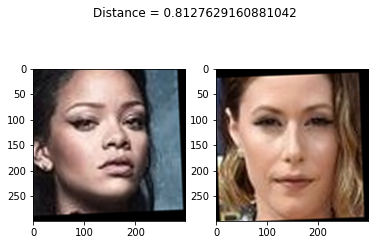

In [ ]:
Solution(10000,200)
#Example1 of different images

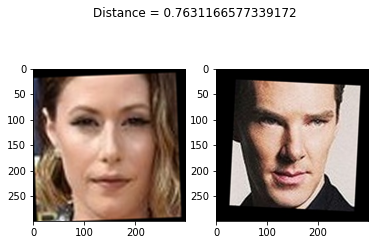

In [ ]:
Solution(200,500)
#Example2 of different images

In [ ]:
L2_distance(embedding_pred_all[20],embedding_pred_all[500])

0.01688405602984378

## **Use PCA for dimensionality reduction.**

In [ ]:
embedding_pred_all = embedding_pred_all[0:1000]
#We take only first 1000 data as we will do PCA and then apply SVC which takes more time (Ran for 4hrs and colab crashed) to process and get trained

In [ ]:
# embedding_pred_all
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X = embedding_pred_all
y = Data['class'].iloc[0:1000]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [ ]:
pca = PCA() 
XT = pca.fit_transform(X_train) 
explained_variance = pca.explained_variance_ratio_ 
print(explained_variance)

[1.58524781e-01 9.56495670e-02 7.43845454e-02 6.37424664e-02
 5.81171533e-02 4.45361545e-02 3.76282573e-02 3.14765758e-02
 2.26844324e-02 2.13700834e-02 1.90014575e-02 1.69648191e-02
 1.49466708e-02 1.32163786e-02 1.16378351e-02 9.98350416e-03
 9.79664172e-03 9.06603503e-03 8.44915459e-03 8.00248360e-03
 7.40783466e-03 7.00311966e-03 6.52990805e-03 6.17104922e-03
 5.97229867e-03 5.78478114e-03 5.43528439e-03 5.26100009e-03
 5.06019670e-03 4.83291516e-03 4.71300873e-03 4.54811419e-03
 4.24476302e-03 4.03888211e-03 3.98001756e-03 3.81022715e-03
 3.69575448e-03 3.61985307e-03 3.47122434e-03 3.31981517e-03
 3.22475267e-03 3.13693811e-03 2.94155897e-03 2.78664207e-03
 2.75634332e-03 2.68663872e-03 2.44515913e-03 2.39086347e-03
 2.36154892e-03 2.27243574e-03 2.20197548e-03 2.19237015e-03
 2.10676431e-03 2.08445246e-03 2.00919910e-03 1.96812886e-03
 1.82705119e-03 1.79337874e-03 1.75530526e-03 1.74227207e-03
 1.69969509e-03 1.68328836e-03 1.59536746e-03 1.56925355e-03
 1.53384640e-03 1.503756

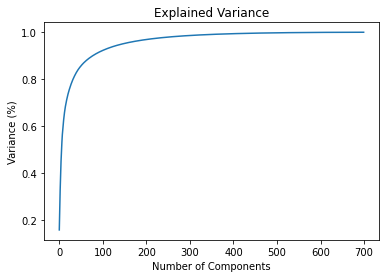

In [ ]:
plt.figure()
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.title('Explained Variance')
plt.show()

#We see that somewhere around 300 - 400, the variance percentage explained touches 90% and above and then flattens out, we pick 300

In [ ]:
pca = PCA(n_components=300) 
#Recreating PCA object with 300 components

X_train_pca = pca.fit_transform(X_train) 
#Fit transform the training data

X_test_pca = pca.transform(X_test) 
#Transform the test data to prevent data leaking

## Encoding the labels

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

## Build an SVM classifier to map each image to its right person.

In [ ]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train,y_train)
svc_pred = svc.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

print(f'Accuracy of SVC Model :{accuracy_score(y_test, svc_pred):1.4f}')

#We get 99.67% accuracy without any hyperparameter tuning

Accuracy of SVC Model :0.9967


In [ ]:
feature1, feature2, label_train, label_test = train_test_split(X, y, test_size=0.3,random_state=42)
#This is to find the index position of label_test and then to capture that image

prediction = label_encoder.inverse_transform(svc_pred)
# Inverse transforming the labels so that its easy to cross check the names

pins_Brenton Thwaites



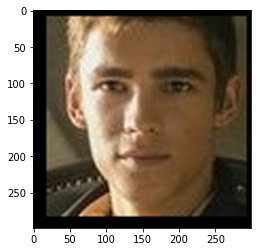

In [ ]:
print(prediction[1]+'\n')
plt.imshow(io.imread(Data['filename'].iloc[label_test.index[1]]))